# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [278]:
import pandas as pd
import numpy as np
from pymystem3 import Mystem

path = '/datasets/data.csv'

In [279]:
df = pd.read_csv(path)

In [280]:
df.shape

(21525, 12)

In [281]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Сразу подправим названия колоноки dob_years на age(возраст клиента), это следует из предусловия к проекту

In [282]:
df.columns = ['children', 'days_employed', 'age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose']
df.columns

Index(['children', 'days_employed', 'age', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [283]:
df.sample()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6201,0,-8908.422866,44,высшее,0,женат / замужем,0,F,сотрудник,0,88335.559745,недвижимость


In [284]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000000,2.000000e+01
days_employed,19351.0,63046.497661,140827.311974,-18388.949901,-2747.423625,-1203.369529,-291.095954,4.017554e+05
age,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000000,1.000000e+00
total_income,19351.0,167422.302208,102971.566448,20667.263793,103053.152913,145017.937533,203435.067663,2.265604e+06


**Вывод**

Датасет состоит из 21525 наблюдений и имеет 12 признаков. Для признаков days_employed и total_income у нас имеются пропуски. Многие признаки имею тип object, остальные данные численные. Сразу видно что признак days_employed имеет отрицательные значения. У признака age среднее и медиана примерно равны, это значит что выбросы если есть, то их немного. total_income похоже имеет выбросы в конце, так как до 75% цифра не критично повышается, также среднее превышает медиану.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [285]:
df[df['days_employed'].isna()].count()

children            2174
days_employed          0
age                 2174
education           2174
education_id        2174
family_status       2174
family_status_id    2174
gender              2174
income_type         2174
debt                2174
total_income           0
purpose             2174
dtype: int64

In [286]:
df[df['days_employed'].isna()]['income_type'].value_counts()

сотрудник          1105
компаньон           508
пенсионер           413
госслужащий         147
предприниматель       1
Name: income_type, dtype: int64

In [287]:
df['days_employed'] = df['days_employed'].fillna(0)
df['total_income'] = df['total_income'].fillna(0)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null float64
age                 21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


In [288]:
# функция оптимизация памяти
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist
df, NAlist = reduce_mem_usage(df)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1.970794677734375  MB
******************************
Column:  children
dtype before:  int64
dtype after:  int8
******************************
******************************
Column:  days_employed
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  age
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  education_id
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  family_status_id
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  debt
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  total_income
dtype before:  float64
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1.0880975723266

In [289]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int8
days_employed       21525 non-null float32
age                 21525 non-null uint8
education           21525 non-null object
education_id        21525 non-null uint8
family_status       21525 non-null object
family_status_id    21525 non-null uint8
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null uint8
total_income        21525 non-null float32
purpose             21525 non-null object
dtypes: float32(2), int8(1), object(5), uint8(4)
memory usage: 10.4 MB


**Вывод**

Мы взяли все наблюдения с пропущенным days_employed и посчитали их во всех столбцах и увидели, что те у кого days_employed пропущено, у тех пропущены и total_income и это логично, те кто не был ни дня трудоустроен - у тех нет дохода. По этому можно заполнить у таких days_employed равным 0 и соотв-но total_income также равным 0.

С другой стороны мы также посмотрели категории income_type у таких наблюдений, их всего 2174, которые как мы понимаем не указали ни дня работы(или не было официально трудоустроены?). Так или иначе для банка их доход и стаж - 0 будет логичнее указать, чем брать среднюю или медиану.

In [290]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
children,21525.0,0.538908,1.381587,-1.000000,0.000000,0.000000,1.000,2.000000e+01
days_employed,21525.0,56678.875000,134870.765625,-18388.949219,-2518.168945,-982.531738,0.000,4.017554e+05
age,21525.0,43.293380,12.574584,0.000000,33.000000,42.000000,53.000,7.500000e+01
education_id,21525.0,0.817236,0.548138,0.000000,1.000000,1.000000,1.000,4.000000e+00
family_status_id,21525.0,0.972544,1.420324,0.000000,0.000000,0.000000,1.000,4.000000e+00
debt,21525.0,0.080883,0.272661,0.000000,0.000000,0.000000,0.000,1.000000e+00
total_income,21525.0,150512.843750,109897.210938,0.000000,88612.835938,135514.718750,195543.625,2.265604e+06


### Замена типа данных и работа с аномальными значениями

In [291]:
df['gender'].unique()

array(['F', 'M', 'XNA'], dtype=object)

'XNA' - непонятный тип и сложно предположить каким он мог бы быть

In [292]:
df['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

У нас один непонятный "вброс", давайте посмотрим все наблюдение:

In [293]:
df[df['gender'] == 'XNA']

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,-2358.600586,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.15625,покупка недвижимости


Допустим я не хочу выкидывать это наблюдение(хотя оно всего 1/21525 или весьма незначительная часть)

In [294]:
temp = df[df['education'] == 'неоконченное высшее']
temp = temp[temp['family_status'] == 'гражданский брак']
temp = temp[temp['purpose'] == 'покупка недвижимости']
temp

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
6859,1,-260.992737,0,неоконченное высшее,2,гражданский брак,1,F,сотрудник,0,128246.648438,покупка недвижимости
10701,0,-2358.600586,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905.156250,покупка недвижимости


Эти 2 наблюдения не помогли мне понять возраст, но я обнаружила наблюдение с age = 0, запомним это. Удалим наблюдение с gender XNA

In [295]:
df = df.drop(np.where(df['gender'] == 'XNA')[0])
df[df['gender'] == 'XNA']

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose


In [296]:
df['gender'].unique()

array(['F', 'M'], dtype=object)

In [297]:
def gender_convert(gender):
    """
    Возвращает пол: 0 - женщины, 1 - мужчины.
    """
    if gender == 'F':
        return 0
    else:
        return 1

In [298]:
df['gender'] = df['gender'].apply(gender_convert)
df['gender'].value_counts()

0    14236
1     7288
Name: gender, dtype: int64

Женщин почти в 2 раза больше чем мужчин и тип 'gender' больше не object

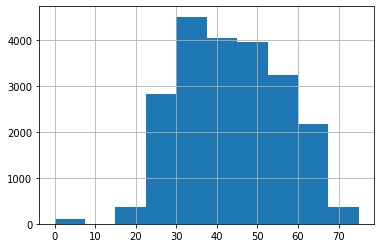

In [299]:
df['age'].hist()

In [300]:
df[df['age'] == 0]['age'].count()

101

Таких наблюдений 101 или менее 0.001 процента данных, что несущественно. При этом же их сложно будет заполнить, так как придется высчитывать среднее или медиану, что с возрастом не будет показательно. Удалим такие наблюдения.

In [301]:
df.drop(df[df['age'] == 0].index, inplace=True)
df[df['age'] == 0]['age'].count()

0

In [302]:
df['children'].value_counts()

 0     14079
 1      4802
 2      2042
 3       328
 20       75
-1        47
 4        41
 5         9
Name: children, dtype: int64

Столбец children явно имеет некорректные отрицательные значения

In [303]:
def to_positive(number):
    return abs(number)

In [304]:
df['children'] = df['children'].apply(to_positive)
df['children'].value_counts()

0     14079
1      4849
2      2042
3       328
20       75
4        41
5         9
Name: children, dtype: int64

У нас много наблюдений с 20 детьми при этом пропущенные промежуточные значения. Можно предположить что была гос программа для семей с 20 детьми, но более вероятно, что нам пришли данные где дополнительно к "2" отправился "0", и мы могли бы заменить 20 на 2.

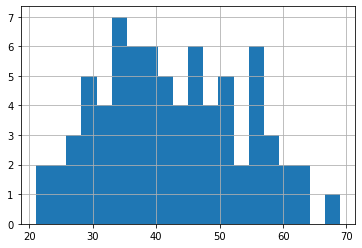

In [305]:
df[df['children'] == 20]['age'].hist(bins=20)

Также можно было бы предположить, что те, у кого 20 детей это взрослые заемщики, ну как минимум 40 лет, но мы видим что у нас различные возраста

In [306]:
len(df[(df['children'] == 20) & (df['age'] < 30)])

9

Или например много детей усыновили. Но все же остановлюсь на том, что скорее всего это была цифра 2(но все же заодно сделаем запрос к разработчикам по вопросу возможной причины поступления такого рода "выброса")

In [307]:
def children_to_two(children):
    if children == 20:
        return 2
    else:
        return children

In [308]:
df['children'] = df['children'].replace(20, 2)
df['children'].value_counts()

0    14079
1     4849
2     2117
3      328
4       41
5        9
Name: children, dtype: int64

In [309]:
df['days_employed'].value_counts()

 0.000000         2164
-1272.242310         2
 334679.125000       2
-1510.738159         2
 375045.281250       2
                  ... 
-597.273376          1
-597.273438          1
 358738.843750       1
-1066.557983         1
-487.956421          1
Name: days_employed, Length: 19254, dtype: int64

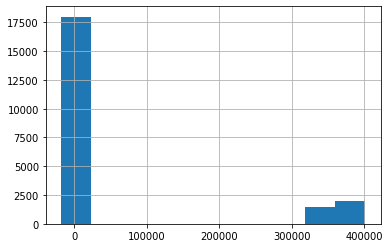

In [310]:
df['days_employed'].hist(bins=10)

Отрицательные значения похожи на результат некорректного заполнения формы или передачи данных, по логике распределение должно выглядить как уменьшение количества наблюдений где количество дней стажа растет, проверим это переведя отрицательные значения в положительные и построив график их распределения

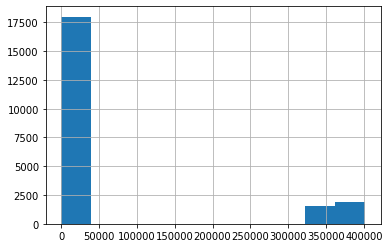

In [311]:
df['days_employed'] = df['days_employed'].apply(to_positive)
df['days_employed'].hist(bins=10)

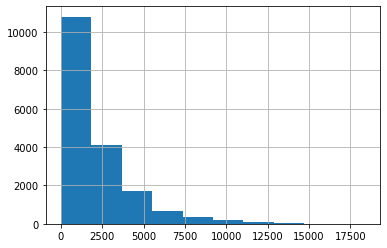

In [312]:
df[df['days_employed'] < 50000]['days_employed'].hist(bins=10)

Распределение стало похожим на правду. 50*365 = 18250 дней - допустим, что максимальный стаж такой, проверим это

In [313]:
df[(df['days_employed'] > 18250) & (df['days_employed'] < 30000)]['days_employed']

16335    18388.949219
Name: days_employed, dtype: float64

Получили что есть еще наблюдение с адекватным количеством дней - 18388.949901, включим его, тогда все что выше будем считать неадекватным. Допустим, что все что выше было случайно переведено в некорректный формат, обычно со временем и датами это умножение на 24 или наоброт. Поступим так, все что выше 60 лет будет неадекватно(до 60 лет - например есть работники мвд рф или работники крайнего севера, где стаж считается иначе и такое вполне может быть). Тогда:

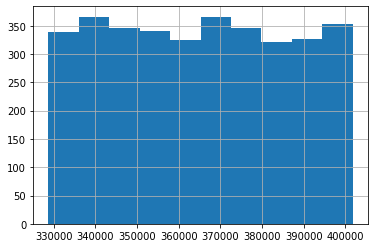

In [314]:
df[df['days_employed'] > 21900]['days_employed'].hist(bins=10)

In [315]:
df[df['days_employed'] > 21900]['income_type'].value_counts()

пенсионер      3426
безработный       2
Name: income_type, dtype: int64

Изучили наши наблюдения с аномальными днями работы и видим что большинство из них это пенсионеры, то есть стаж должен быть большой по идее

Переведем предполагаемые минуты в часы поделив на 24


In [316]:
def to_hours(minutes):
    if minutes > 21900:
        return minutes / 24
    else:
        return minutes

In [317]:
df['days_employed'] = df['days_employed'].apply(to_hours)

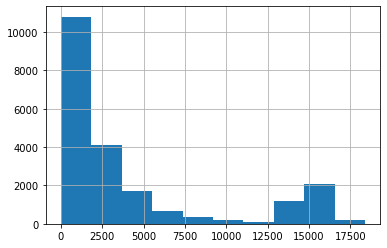

In [318]:
df[df['days_employed'] < 21900]['days_employed'].hist(bins=10)

In [319]:
df[(df['days_employed'] > 0) & (df['days_employed'] < 10000)]['income_type'].value_counts()

сотрудник          9800
компаньон          4503
госслужащий        1267
в декрете             1
предприниматель       1
студент               1
Name: income_type, dtype: int64

В целом значения адекватные.

In [320]:
df['debt'].value_counts()

0    19690
1     1733
Name: debt, dtype: int64

Преобладают значения 0 - те кто не имел задолженность по возврату кредита

**Вывод**

Мы просмотрели численные переменные и построили графики что бы зрительно увидеть наличие аномалий и некорректных значений, например отрицательных чисел. Также перевели "gender" в 0 и 1 что бы удобнее было с ними работать

### Обработка дубликатов

In [321]:
df.duplicated().sum()

54

In [322]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

**Вывод**

Удаляем очевидные дубликаты с помощью df.drop_duplicates().reset_index(drop=True), что бы не создавать столбец со старыми значениями индексов

### Лемматизация

In [323]:
m = Mystem()

In [324]:
key_list = ['свадьба', 'недвижимость', 'автомобиль', 'образование', 'жилье']
purpose = {}
for reason in list(df['purpose'].values):
    lemma = m.lemmatize(reason)
    for key in key_list:
        if key in lemma:
            if purpose.get(key):
                if lemma not in purpose[key]:
                    purpose[key].append(lemma)
            else:
                purpose[key] = [lemma]

In [325]:
for key, value in purpose.items():
    print(key, value)
    print('-'*100)

жилье [['покупка', ' ', 'жилье', '\n'], ['операция', ' ', 'с', ' ', 'жилье', '\n'], ['покупка', ' ', 'жилье', ' ', 'для', ' ', 'семья', '\n'], ['жилье', '\n'], ['покупка', ' ', 'свой', ' ', 'жилье', '\n'], ['покупка', ' ', 'жилье', ' ', 'для', ' ', 'сдача', '\n'], ['ремонт', ' ', 'жилье', '\n']]
----------------------------------------------------------------------------------------------------
автомобиль [['приобретение', ' ', 'автомобиль', '\n'], ['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n'], ['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n'], ['автомобиль', '\n'], ['сделка', ' ', 'с', ' ', 'подержанный', ' ', 'автомобиль', '\n'], ['свой', ' ', 'автомобиль', '\n'], ['сделка', ' ', 'с', ' ', 'автомобиль', '\n'], ['на', ' ', 'покупка', ' ', 'автомобиль', '\n']]
----------------------------------------------------------------------------------------------------
образование [['дополнительный', ' ', 'образование', '\n'], ['образование', '\n'], ['заниматься', 

1. Что касается автомобилей, то по сути это все покупка движимого имущества, которое банк может забрать в случае невыплаты, но такое имущество не так ликвидно как например недвижимое. Оставим здесь "покупка автомобиля"
2. Что касается образования, то с одной стороны я бы оставила просто образование. Если у нас есть колонка возраст, то это дополнительно даст нам понимание, и мы можем понимать, что есть age = 16 который хочет взять заем или age = 30 который хочет взять заем. С другой стороны age = 23 также может брать заем на высшее как первое так и на второе. Но все это объединяет то, что в случае не выплаты банк не сможет явно взять что-то существенное, по этому оставим это как "нецелевой потребительский кредит"
3. Со свадьбой всего 3 значения и сводятся к "свадьба" - это нецелевой потребительский кредит, банк в случае невыплат по кредиту ничего забрать обратно не сможет. Объединим с ремонтом в "нецелевой потребительский кредит"
4. С недвижимостью сложнее. С одной стороны это ликвид для банка, но если это **строительство** собственной недвижимости, то это похоже на нецелевой кредит, то есть ипотека, но банк не знает что в итоге будет построено, ему никто гарантий не дает, а мы знаем что кредит выдают физ лицам. **Строительство** недвижимости все же будем считать что это не коммерческая недвижимость, а жилая, так как для того что бы построить такую ему надо зарегать юр. лицо. Если речь идет о **коммерческой/жилой** недвижимости думаю стоит объединить в одно, тут не вижу принципиальной разницы, другие факторы будут не менее важными. По **операциям** с недвижимостью не ясно что это

In [326]:
def cat_purpose(purpose):
    lemma = m.lemmatize(purpose)
    if 'автомобиль' in lemma:
        return "покупка автомобиля"
    elif 'дополнительный' in lemma and 'образование' in lemma:
        return "нецелевой потребительский кредит"
    elif 'высокий' in lemma and 'образование' in lemma:
        return "нецелевой потребительский кредит"
    elif "образование" in lemma:
        return "нецелевой потребительский кредит"
    elif ("свадьба" in lemma or "ремонт" in lemma):
        return "нецелевой потребительский кредит"
    elif ("операция" in lemma and "недвижимость" in lemma) or ("операция" in lemma and "жилье" in lemma):
        return "нецелевой потребительский кредит"
    elif "строительство" in lemma and "недвижимость" in lemma:
        return "нецелевой потребительский кредит"
    elif ("покупка" in lemma and "недвижимость" in lemma) or ("покупка" in lemma and "жилье" in lemma):
        return "покупка недвижимости"
    elif "недвижимость" in lemma or "жилье" in lemma:
        return "нецелевой потребительский кредит"

In [327]:
df['purpose'] = df['purpose'].apply(cat_purpose)
df['purpose'].value_counts()

нецелевой потребительский кредит    12658
покупка недвижимости                 4425
покупка автомобиля                   4286
Name: purpose, dtype: int64

**Вывод**

Мы обработали данные категории purpose и выявили что у нас в основе своей повторяющиеся слова, а также свели их к 3-м категориям по признаку цели покупки: целевая - это машина или недвижимость и нецелевая покупка. Да, возможно здесь можно было бы выделить больше категорий, но я подходила исходя как если бы это разделение делал банк

### Категоризация данных

In [328]:
df['education'].value_counts()

среднее                13646
высшее                  4678
СРЕДНЕЕ                  770
Среднее                  708
неоконченное высшее      665
ВЫСШЕЕ                   272
Высшее                   266
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [329]:
df['education_id'].value_counts()

1    15124
0     5216
2      741
3      282
4        6
Name: education_id, dtype: int64

Мы видим, что в столбце education есть повторы, и если их свести к единому формату, то у нас также как и в education_id будет 5 категорий, сделаем это

In [330]:
df['education'] = df['education'].str.lower()

In [331]:
df.groupby('education')['education_id'].count().sort_values()

education
ученая степень             6
начальное                282
неоконченное высшее      741
высшее                  5216
среднее                15124
Name: education_id, dtype: int64

Мы видим что категории education и education_id совпадают, при это числовые значения id не отражают какой либо зависимости, то есть за числами нет логики. Так как это повторяющийся столбец, то его стоит удалить. В будущем, если нам надо будет использовать числовое значение, то мы можем перевести в числа 

In [332]:
df = df.drop(['education_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21369 entries, 0 to 21368
Data columns (total 11 columns):
children            21369 non-null int64
days_employed       21369 non-null float64
age                 21369 non-null uint8
education           21369 non-null object
family_status       21369 non-null object
family_status_id    21369 non-null uint8
gender              21369 non-null int64
income_type         21369 non-null object
debt                21369 non-null uint8
total_income        21369 non-null float32
purpose             21369 non-null object
dtypes: float32(1), float64(1), int64(2), object(4), uint8(3)
memory usage: 1.3+ MB


In [333]:
df.groupby('family_status')['family_status_id'].count().sort_values()

family_status
вдовец / вдова             954
в разводе                 1185
Не женат / не замужем     2794
гражданский брак          4141
женат / замужем          12295
Name: family_status_id, dtype: int64

Аналогично поступим и тут с family_status_id

In [334]:
df = df.drop(['family_status_id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21369 entries, 0 to 21368
Data columns (total 10 columns):
children         21369 non-null int64
days_employed    21369 non-null float64
age              21369 non-null uint8
education        21369 non-null object
family_status    21369 non-null object
gender           21369 non-null int64
income_type      21369 non-null object
debt             21369 non-null uint8
total_income     21369 non-null float32
purpose          21369 non-null object
dtypes: float32(1), float64(1), int64(2), object(4), uint8(2)
memory usage: 1.3+ MB


При этом гражданский брак и женат / замужем строго говоря с юридической точки зрения - одно и тоже - объединим в одну категорию(а главное для банка это одно и тоже)

In [335]:
df['family_status'] = df['family_status'].replace('гражданский брак', 'женат / замужем')
df['family_status'].value_counts()

женат / замужем          16436
Не женат / не замужем     2794
в разводе                 1185
вдовец / вдова             954
Name: family_status, dtype: int64

In [336]:
df['income_type'].value_counts()

сотрудник          11036
компаньон           5059
пенсионер           3817
госслужащий         1451
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

Здесь я бы также объединила "сотрудник" и "компаньон", так как по сути для банка это одна категория наемные рабочие

In [337]:
df['income_type'] = df['income_type'].replace('сотрудник', 'работник')
df['income_type'] = df['income_type'].replace('компаньон', 'работник')
df['income_type'].value_counts()

работник           16095
пенсионер           3817
госслужащий         1451
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

**Вывод**

1. Мы удалили дублирующие уже категории столбцы,
2. Объединили категории там, где у нас были caps lock или иные по смыслу одинаковые категории

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

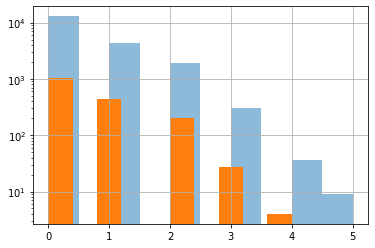

In [338]:
df[df['debt'] == 0]['children'].hist(log=True, alpha=0.5)
df[df['debt'] == 1]['children'].hist(log=True)

На графике видно, что чем больше детей тем меньше таких наблюдений, а также что  снижение происходит примерно одинаково на обоих графиках

In [339]:
df[(df['debt'] == 0) & (df['children'] == 0)]['children'].count() / len(df)

0.607375169638261

~60% не имели задолженность из тех у кого нет детей

In [340]:
df[(df['debt'] == 0) & (df['children'] > 0)]['children'].count() / len(df)

0.3115260423978661

~31% не имели задолженность из тех у кого есть дети

In [341]:
df[(df['debt'] == 1) & (df['children'] == 0)]['children'].count() / len(df)

0.04951097384061023

~5% имели задолженность из тех у кого нет детей

In [342]:
df[(df['debt'] == 1) & (df['children'] > 0)]['children'].count() / len(df)

0.03158781412326267

~3% имели задолженность из тех у кого есть дети

In [343]:
31 / 91

0.34065934065934067

In [344]:
3 / 8

0.375

**Вывод**

Из 91% кто не имеет задолженность у 60% нет детей,
И при этом из 9% что имеют задолженность - 5% не имеют детей. 
То есть в обоих выборках для тех кто имеет задолженность и тех кто не имеет большая часть не имеет детей. 
Среди тех кто не имел задолженность дети есть у 34%, а среди тех кто имел - 37,5%, то есть слабая зависимость от количества детей есть

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [345]:
for status in list(df['family_status'].unique()):
    stat = []
    for d in list(df['debt'].unique()):
        pers = df[(df['family_status'] == status) & (df['debt'] == d)]['debt'].count() / len(df)
        stat.append(pers)
        if len(stat) == len(list(df['debt'].unique())):
            print(f"В категории '{status}' отношение невозвратов к всем наблюдениям по этой категории: {stat[1]/(stat[0] + stat[1]):.1%}")
        # print(f"{pers:.2%} для статус {status} и debt={d}")

В категории 'женат / замужем' отношение невозвратов к всем наблюдениям по этой категории: 8.0%
В категории 'вдовец / вдова' отношение невозвратов к всем наблюдениям по этой категории: 6.5%
В категории 'в разводе' отношение невозвратов к всем наблюдениям по этой категории: 7.2%
В категории 'Не женат / не замужем' отношение невозвратов к всем наблюдениям по этой категории: 9.8%


**Вывод**

Большая доля невозвратов среди неженатых и незамужних, а наименьшая доля невозвратов среди вдов и вдовцов.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Здесь по аналогии с анализом выше можно было бы для каждого наблюдения или категории посчитать, но их вариативность слишком большая, посмотрим на распределение и разобьем на диапазоны

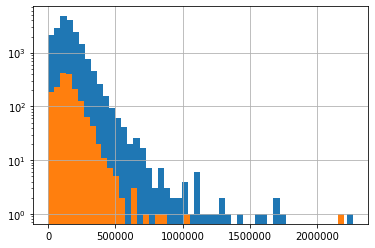

In [346]:
df[df['debt'] == 0]['total_income'].hist(log=True, bins=50)
df[df['debt'] == 1]['total_income'].hist(log=True, bins=50)

In [347]:
df['total_income'].describe()

count    2.136900e+04
mean     1.509278e+05
std      1.098811e+05
min      0.000000e+00
25%      8.895144e+04
50%      1.357190e+05
75%      1.957379e+05
max      2.265604e+06
Name: total_income, dtype: float64

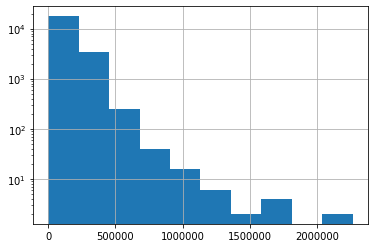

In [348]:
df['total_income'].hist(log=True)

In [354]:
income = {
    'first': [df['total_income'].min(), df['total_income'].quantile(0.25)],
    'second': [df['total_income'].quantile(0.25), df['total_income'].median()],
    'third': [df['total_income'].median(), df['total_income'].quantile(0.75)],
    'fourth': [df['total_income'].quantile(0.75), df['total_income'].max()],
}

for key, value in income.items():
    stat = []
    for d in list(df['debt'].unique()):
        selection = df[(df['total_income'] >= value[0]) & (df['total_income'] < value[1]) & (df['debt'] == d)]['debt'].count()
        pers = selection / len(df)
        stat.append(pers)
        if len(stat) == len(list(df['debt'].unique())):
            print(f"Диапозон дохода: {value[0]} - {value[1]}")
            print(f"В категории '{key}' отношение невозвратов к всем наблюдениям по этой категории: {stat[1]/(stat[0] + stat[1]):.1%}")
        # print(f"{pers:.2%} для статус {status} и debt={d}")

Диапозон дохода: 0.0 - 88951.4375
В категории 'first' отношение невозвратов к всем наблюдениям по этой категории: 7.8%
Диапозон дохода: 88951.4375 - 135719.0
В категории 'second' отношение невозвратов к всем наблюдениям по этой категории: 8.4%
Диапозон дохода: 135719.0 - 195737.890625
В категории 'third' отношение невозвратов к всем наблюдениям по этой категории: 9.0%
Диапозон дохода: 195737.890625 - 2265604.0
В категории 'fourth' отношение невозвратов к всем наблюдениям по этой категории: 7.2%


**Вывод**

Получается, что чем больше доход - тем больше должников, по крайней мере эта тенденция видна в первых трех группах, а в последней доля даже ниже чем в первой, что может говорить и о не репрезентативной выборке или выбросах или всеже богатые реже берут кредиты или берут меньшие кредиты.

- Как разные цели кредита влияют на его возврат в срок?

In [350]:
df['purpose'].value_counts()

нецелевой потребительский кредит    12658
покупка недвижимости                 4425
покупка автомобиля                   4286
Name: purpose, dtype: int64

In [382]:
for status in list(df['purpose'].unique()):
    stat = []
    for d in list(df['debt'].unique()):
        pers = df[(df['purpose'] == status) & (df['debt'] == d)]['debt'].count() / len(df)
        stat.append(pers)
        if len(stat) == len(list(df['debt'].unique())):
            print(f"В категории '{status}' отношение невозвратов к всем наблюдениям по этой категории: {stat[1]/(stat[0] + stat[1]):.1%}")
        # print(f"{pers:.2%} для статус {status} и debt={d}")

В категории 'покупка недвижимости' отношение невозвратов к всем наблюдениям по этой категории: 7.0%
В категории 'покупка автомобиля' отношение невозвратов к всем наблюдениям по этой категории: 9.3%
В категории 'нецелевой потребительский кредит' отношение невозвратов к всем наблюдениям по этой категории: 8.1%


**Вывод**

Я вижу что 'покупка недвижимости' имеет самый низкий процент невозвратов, в то время как покупка авто самый высокий. 

## Шаг 4. Общий вывод

1. 66% людей, не имеющих задолженности по кредиту не имеют детей(60*100/91).
2. 9.8% в категории "не женатых / не замужних" имеют задолженности против 6.5% в категории 'вдовец / вдова'. Кредитовать выгоднее вдов и вдовцов.
3. Наибольшая доля должников находится в диапазоне зарплат между 135719 и 195737 - их 9%. Выгоднее давать кредит тем, у кого диапазон зарплаты выше 195737 - доля невозвратов в этой категории 7.2%
4. Выгоднее всего давать ипотечные кредиты - 93% исправно их выплачивают, при этом наимее выгодно давать кредит на покупку авто - 9.3% таких кредитов имеют задолженности.
5. Таким образом наибольшая вероятность **не иметь задолженности** по кредиту на недвижимость у бездетных вдовцов с доходом выше 195737. А наибольшая вероятность **иметь задолженность** у наблюдей, берущих кредит на автомобиль, имеющих детей, не замужних/не женатых с доходом между 135718 и 195737.